# Exploratory Data Analysis for structured HDF5 files 
This notebook show us how to access HDF5 data from Python.  

In this case we going to use a structured HDF5 file to access to timestamps for an experiment. We going to explore Groups, Attributes and Dataset in the file and also we going to look at three examples to plot data.

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

# Load Data

In [4]:
filename = '../data/structured_data/structured_data_2018-01-25.hdf5'
# filename = '../data/structured_data/structured_data_2018-04-18.hdf5'
hdf_file = h5py.File(filename, 'r')

# Groups
Groups are the HDF5 container object, analogous to folders in a filesystem. They can hold dataset or other groups.     

We can get information about the  groups using iterators of Python.

In [3]:
print('{:<25s}  {}'.format('GROUP','DESCRIPTION'))

for name, group in hdf_file.items():
    print('{:<25s}: {}'.format(name,group))

GROUP                      DESCRIPTION
response                 : <HDF5 group "/response" (11 members)>
stimulus                 : <HDF5 group "/stimulus" (2 members)>
sync                     : <HDF5 group "/sync" (11 members)>


File has two principal groups, **'/response'** and **'/stimulus'**. We can get information about the  subgroups usinig Dict style, hdf_file\['response'\].

Below we get information about all subgrop in '/response' group, each subgrup in this case is a protocol.

In [4]:
print('{:<25s}  {}'.format('GROUP','DESCRIPTION'))
for name, group in hdf_file['/response/'].items():
    print('{:<25s}: {}'.format(name,group))

GROUP                      DESCRIPTION
checkerboard             : <HDF5 group "/response/checkerboard" (329 members)>
chirp                    : <HDF5 group "/response/chirp" (329 members)>
natural_image            : <HDF5 group "/response/natural_image" (329 members)>
natural_image_BGA        : <HDF5 group "/response/natural_image_BGA" (329 members)>
natural_image_inv        : <HDF5 group "/response/natural_image_inv" (329 members)>
natural_image_inv_BGA    : <HDF5 group "/response/natural_image_inv_BGA" (329 members)>
natural_image_shuffle    : <HDF5 group "/response/natural_image_shuffle" (329 members)>
natural_image_shuffle_BGA: <HDF5 group "/response/natural_image_shuffle_BGA" (329 members)>
photopic                 : <HDF5 group "/response/photopic" (329 members)>
scotopic                 : <HDF5 group "/response/scotopic" (329 members)>
tail                     : <HDF5 group "/response/tail" (329 members)>


## Attriubutes
Attributes describe Groups and Dataset and with this  we can get information about our data.

In this example we will show the attributes of a particular protocols.

In [5]:
protocol_name = '/response/natural_image'
attrs = hdf_file[protocol_name].attrs
for name, value in attrs.items():
    print('{:<20}: {}'.format(name,value))

end_time            : 66049493
start_time          : 65447011
duration            : 30.1241
sample_rate         : 20000
presentation_number : 4


Above we can see different attributes of the selected protocol, in this case we will choose **'duration'** and **'sample_rate'**.

In [6]:
time_stim = attrs['duration']
sample = attrs['sample_rate']

# Data sets
A dataset is similar to Numpy Array and we can use 'slicing', and 'steps' using the same way \[star:end:step\].    

Dataset and Numpy array are objets with atributs as f.size, f.shape, f.dtype.

For example we can take all timestamp in a single template for the checkerboar protocol. 


In [7]:
units = [unit for unit in hdf_file['/response/checkerboard']]

print('Some units in the protocol: \n    {}\n'.format(units[:5]))

dataset_path = '/response/checkerboard/temp_0'

print('Dataset object: \n '+str(hdf_file[dataset_path]))
print('Dataset values: \n '+str(hdf_file[dataset_path][...]))


Some units in the protocol: 
    ['temp_0', 'temp_1', 'temp_10', 'temp_100', 'temp_101']

Dataset object: 
 <HDF5 dataset "temp_0": shape (1521,), type "<i4">
Dataset values: 
 [    5288    18430    19035 ... 24149634 24224862 24228015]


Above we can show that 'temp_0' and how we can get the array quickly.

# Examples

Examples has a slider to change the unit to analize. It's a nice way to interact easyly with the data.

In [6]:
# protocol_name = '/response/chirp'
protocol_name = '/response/natural_image'
protocol = hdf_file[protocol_name]
nunits = len(protocol)

## Plot raster for a single unit

In [9]:
def singleRaster(number_unit=0):
    time_stim = protocol.attrs['duration']
    sample = protocol.attrs['sample_rate']
    
    unit = 'temp_{}'.format(number_unit)
    repetitions = protocol[unit]

    
    plt.figure(figsize=(10,5))
    for kidx,krep in enumerate(repetitions):
        data_plot = repetitions[krep][...]/sample
        plt.plot(data_plot,kidx*np.ones_like(data_plot),marker='|',linestyle='')
    plt.xlim([-1,time_stim+1])
    plt.title(unit)
    plt.xlabel('Time [s]')
    plt.ylabel('Trials')
    plt.show()

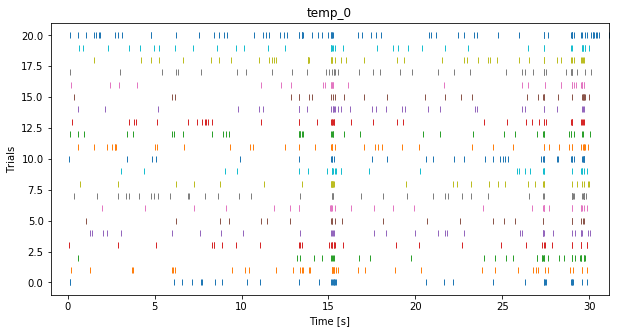

In [10]:
interact(singleRaster, number_unit=(0,nunits-1,1));

## Plot psth for a single unit

In [72]:
def singlePSTH(number_unit=0):
    time_stim = protocol.attrs['duration']
    sample = protocol.attrs['sample_rate']
    
    unit = 'temp_{}'.format(number_unit)
    repetitions = protocol[unit]
    
    spikes = []
    for ktrial,kvalues in repetitions.items():
        spikes += list(kvalues/sample)

    plt.figure(figsize=(10,5))
    ncount,bins = np.histogram(spikes,bins=int(time_stim*100),range=(0,time_stim))
    plt.step(bins[:-1],ncount)
    plt.xlim([-1,time_stim+1])
    plt.xlabel('Time [s]')
    plt.ylabel('Firing Rate [spk/10ms]')
    plt.show()   

In [73]:
print('Use the slidebar to change the unit.')
interact(singlePSTH, number_unit=(0,nunits-1,1));

Use the slidebar to change the unit.


interactive(children=(IntSlider(value=0, description='number_unit', max=328), Output()), _dom_classes=('widget-interact',))

# Response and stimulus together
Finally we can merge the response with the stimulus to show them together.
## Example Chirp protocol

In [5]:
# stimulus
stim = hdf_file['/stimulus/chirp'][...]
stim_amp  = stim/255.0
sr = hdf_file['/response/chirp'].attrs['sample_rate']
stim_time = hdf_file['/sync/chirp/rep_01']
stim_time_real = np.concatenate((stim_time[:,0],stim_time[-1:,1]))/sr
stim_time_theor = np.linspace(0,2101/60,2101)

# response
protocol_name = '/response/chirp'
protocol = hdf_file[protocol_name]
nunits = len(protocol)
sample = protocol.attrs['sample_rate']

time_stim = protocol.attrs['duration']
sample_stim = protocol.attrs['sample_rate']

def plotChirp(number_unit=221):
    unit = 'temp_{}'.format(number_unit)
    repetitions = protocol[unit]
    
    # get the all timistamps from all repetitions
    spikes = []
    for ktrial,kvalues in repetitions.items():
        spikes += list(kvalues/sample)
    
    # Plot figure
    plt.figure(figsize=(10,5))
    ncount,bins = np.histogram(spikes,bins=int(time_stim*100),range=(0,time_stim))
    plt.step(bins[:-1],ncount,'g',label='Response')
    plt.step(stim_time_real,stim_amp*15,alpha=0.5,color='b',label='Real fps')
    plt.step(stim_time_theor,stim_amp*15,alpha=0.5,color='r',label='Theoretic fps')
    plt.xlim([-1,time_stim+1])
    plt.ylim([0,30])
    plt.xlabel('Time [s]')
    plt.ylabel('Firing Rate [spk/10ms]')
    plt.legend()
    plt.show()   

In [6]:
interact(plotChirp, number_unit=(0,nunits-1,1))

interactive(children=(IntSlider(value=221, description='number_unit', max=328), Output()), _dom_classes=('widget-interact',))

<function __main__.plotChirp>

In [76]:
# hdf_file.close()